In [1]:
using ForneyLab, Flux, Plots, Random, LinearAlgebra

# Dataset Generation

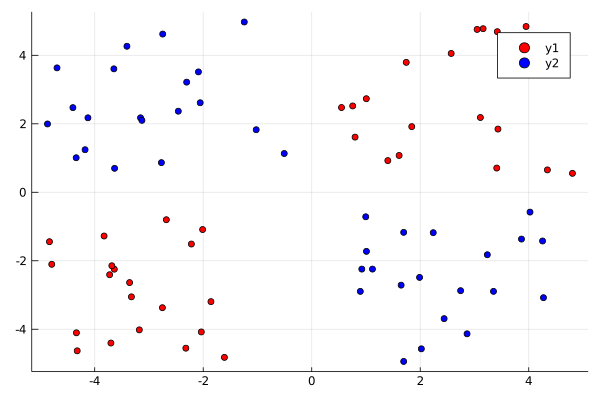

In [2]:
# Number of points to generate
N = 80
M = round(Int, N / 4)
Random.seed!(1234)

# Generate artificial data
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
xt1s = Array([[x1s[i] + 0.5; x2s[i] + 0.5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
append!(xt1s, Array([[x1s[i] - 5; x2s[i] - 5] for i = 1:M]))

x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
xt0s = Array([[x1s[i] + 0.5; x2s[i] - 5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
append!(xt0s, Array([[x1s[i] - 5; x2s[i] + 0.5] for i = 1:M]))

# Store all the data for later
xs = [xt1s; xt0s]
ts = [ones(2*M); zeros(2*M)]

# Plot data points
function plot_data()
    x1 = map(e -> e[1], xt1s)
    y1 = map(e -> e[2], xt1s)
    x2 = map(e -> e[1], xt0s)
    y2 = map(e -> e[2], xt0s)

    Plots.scatter(x1,y1, color="red", clim = (0,1))
    Plots.scatter!(x2, y2, color="blue", clim = (0,1))
end

plot_data()

# Helpers

In [3]:
# Turn a vector into a set of weights and biases
function unpack(nn_params)
    W₁ = reshape(nn_params[1:6], 3, 2);   
    b₁ = nn_params[7:9]
    
    W₂ = reshape(nn_params[10:15], 2, 3); 
    b₂ = nn_params[16:17]
    
    Wₒ = reshape(nn_params[18:19], 1, 2); 
    bₒ = nn_params[20:20]
    return W₁, b₁, W₂, b₂, Wₒ, bₒ
end

# Construct a neural network using Flux and return a predicted value
function nn_forward(xs, nn_params)
    W₁, b₁, W₂, b₂, Wₒ, bₒ = unpack(nn_params)
    nn = Chain(Dense(W₁, b₁, tanh),
               Dense(W₂, b₂, tanh),
               Dense(Wₒ, bₒ, σ))
    return nn(xs)[1]
end;

# Model Specification

The `Nonlinear{Conjugate}` node can be used for approximating a complicated density function with an exponential family distribution.

In [4]:
fg = FactorGraph()

@RV W ~ GaussianMeanPrecision(zeros(20), 0.3.*diageye(20))
g(W) = W
@RV W_prime ~ Nonlinear{Conjugate}(W, g=g, dims=[(20,), (20,)]) # Use with unit-function to approximate complicated density function

x = Vector{Variable}(undef, N)
s = Vector{Variable}(undef, N)
y = Vector{Variable}(undef, N)
for k=1:N
    @RV x[k]
    @RV s[k] ~ Nonlinear{Sampling}(x[k], W_prime, g=nn_forward, dims=[(2,), (), (20,)])
    @RV y[k] ~ Bernoulli(s[k])

    placeholder(x[k], :x, index=k, dims=(2,))
    placeholder(y[k], :y, index=k)
end

In [5]:
algo = messagePassingAlgorithm(W) # Build algorithm
source_code = algorithmSourceCode(algo)
eval(Meta.parse(source_code));

In [6]:
data = Dict(:x => xs,
            :y => ts)
marginals = step!(data); # Execute inference

In [7]:
# Return the average prediction over multiple samples from weights
function nn_predict(x, num) 
    mean(nn_forward.([x], sample(marginals[:W],num)))
end;

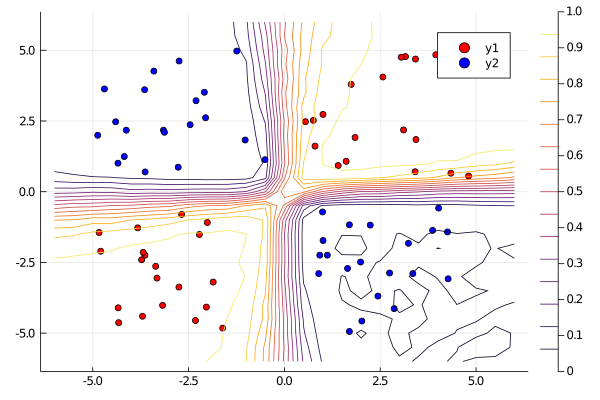

In [8]:
# Plot the average prediction
plot_data()

n_end = 1500
x_range = collect(range(-6,stop=6,length=25))
y_range = collect(range(-6,stop=6,length=25))
Z = [nn_predict([x, y], n_end) for x=x_range, y=y_range]
contour!(x_range, y_range, Z)